In [1]:
import matplotlib.pyplot as plt
from freegs.machine import Solenoid, Machine, MirroredCoil
from freegs.jtor import ConstrainBetapIp
from freegs.equilibrium import Equilibrium
from freegs.control import constrain
from freegs import optimise as opt
from freegs import solve
from SOUTH_param import *

In [2]:
# Parameters subject to change # 
PR1 = 0.50
PZ1 = 0.40
PR2 = 0.60
PZ2 = 0.25
PR3 = 0.65
PZ3 = 0.10

coils_positioning = [
    (PR1, PZ1),
    (PR2, PZ2),
    (PR3, PZ3)
]

Ip = 10e3  # Plasma current [Amps]
toroidal_magnetic_field_strength_at_plasma_centre = 0.125  # B_0

R1 = 0.1
R2 = 0.64

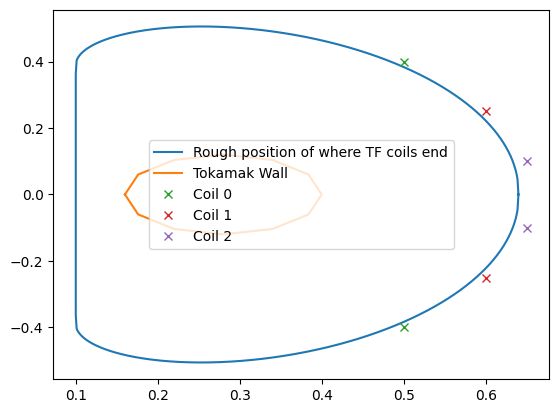

In [3]:
plt.plot(*PrincetonDee(R1, R2), label='Rough position of where TF coils end')
plt.plot(RWall, ZWall, label='Tokamak Wall')

for index, (r, z) in enumerate(coils_positioning):
    plt.plot([r, r], [z, -z], 'x', label='Coil {}'.format(index))
plt.legend()

In [4]:
# Create coils
central_solenoid = [("SOL", Solenoid((inner_radius + outer_radius) / 2, -solenoid_height / 2, solenoid_height / 2,
                                     solenoid_turns, control=False))]
poloidal_coils = [
    ('VF1', MirroredCoil(PR1, PZ1)),
    ('VF2', MirroredCoil(PR2, PZ2)),
    ('SH1', MirroredCoil(PR3, PZ3)),
]

In [5]:
# Create tokamak
tokamak = Machine(
    central_solenoid + poloidal_coils,
    walls
)
tokamak['VF1']['U'].area = \
    tokamak['VF1']['L'].area = \
    tokamak['VF2']['U'].area = \
    tokamak['VF2']['L'].area = \
    tokamak['SH1']['U'].area = \
    tokamak['SH1']['L'].area = \
    4 * 2.1e-4

In [6]:
# Define simulation granularity
eq = Equilibrium(tokamak=tokamak,
                 Rmin=0.01, Rmax=0.7,  # Radial domain
                 Zmin=-0.6, Zmax=0.6,  # Height range
                 nx=129, ny=129  # Number of grid points
                 )

In [7]:
# Define plasma properties constraints
vacuum_toroidal_magnetic_field = plasma_major_radius * toroidal_magnetic_field_strength_at_plasma_centre
profiles = ConstrainBetapIp(eq,
                            0.05,  # Plasma poloidal beta
                            Ip,  # Plasma current [Amps]
                            vacuum_toroidal_magnetic_field)  # Vacuum f=R*Bt

In [8]:
# Define x-points and iso-flux
xpoints = [(0.3, -0.24), (0.3, 0.24)]  # (R,Z) locations of X-points
isoflux = [(0.3, -0.24, 0.3, 0.24)]  # (R1,Z1, R2,Z2) pairs

constraints = constrain(xpoints=xpoints, isoflux=isoflux)

In [9]:
solve(eq,
      profiles,
      constraints,
      check_limited=True,
      limit_it = 0
      )

print(
    tokamak.printCurrents()
)

SOL : Solenoid(Rs=0.055499999999999994, Zsmin=-0.47, Zsmax=0.47, current=0.0, Ns=104, control=False)
VF1 : Circuit([("U", Coil(R=0.5, Z=0.4, current=7220.6, turns=1, control=True), 1.0), ("L", Coil(R=0.5, Z=-0.4, current=7220.6, turns=1, control=True), 1.0)], current=7220.629279605056, control=True)
VF2 : Circuit([("U", Coil(R=0.6, Z=0.25, current=-2391.2, turns=1, control=True), 1.0), ("L", Coil(R=0.6, Z=-0.25, current=-2391.2, turns=1, control=True), 1.0)], current=-2391.1584534152453, control=True)
SH1 : Circuit([("U", Coil(R=0.65, Z=0.1, current=-5550.8, turns=1, control=True), 1.0), ("L", Coil(R=0.65, Z=-0.1, current=-5550.8, turns=1, control=True), 1.0)], current=-5550.756067165398, control=True)
None


/home/roy/DataspellProjects/AtomCraft_Plasma_Modelling/24T2/FreeGS/SOUTH/freegs/critical.py:424: UserWarning: Theta grid too close to X-point, shifting by half-step
  warn("Theta grid too close to X-point, shifting by half-step")


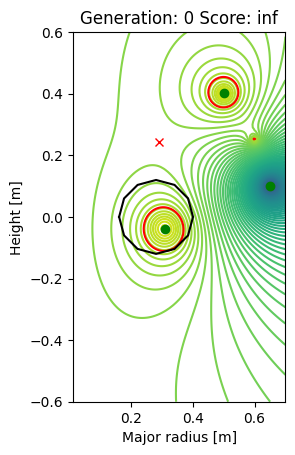

In [ ]:
best_eq = opt.optimise(eq,  # Starting equilibrium 
                       # List of controls
                       [
                           opt.CoilRadius('VF1', minimum=0.25, maximum=0.50),
                           opt.CoilRadius('VF2', minimum=0.35, maximum=0.60),
                           opt.CoilRadius('SH1', minimum=0.45, maximum=0.65),
                           # opt.CoilHeight('VF1'),
                           # opt.CoilHeight('VF2'),
                           # opt.CoilHeight('SH1')
                       ],
                       # The function to minimise
                       opt.weighted_sum(opt.max_abs_coil_current, opt.no_wall_intersection),
                       N=10,  # Number of solutions in each generation
                       maxgen=30 ,  # How many generations
                       monitor=opt.PlotMonitor())  # Plot the best in each generation

In [ ]:
best_eq.tokamak.printCurrents()

In [ ]:
for _, coil in best_eq.tokamak.coils:
    print(coil)

In [ ]:
R1 = best_eq.tokamak['VF1']['U'].R
Z1 = best_eq.tokamak['VF1']['U'].Z
R2 = best_eq.tokamak['VF2']['U'].R
Z2 = best_eq.tokamak['VF2']['U'].Z
R3 = best_eq.tokamak['SH1']['U'].R
Z3 = best_eq.tokamak['SH1']['U'].Z

In [ ]:
coils_positioning = [
    (R1, Z1),
    (R2, Z2),
    (R3, Z3)
]
print(coils_positioning)

In [ ]:
plt.plot(*PrincetonDee(.1, .64), label='Rough position of where TF coils end')
plt.plot(RWall, ZWall, label='Tokamak Wall')

for index, (r, z) in enumerate(coils_positioning):
    plt.plot([r, r], [z, -z], 'x', label='Coil {}'.format(index))
plt.legend()

In [ ]:
best_eq.tokamak.printCurrents()

# Preliminary Results 

In [ ]:
# Adjusting optimised value to suit our tokamak
coils_positioning = [
    (PR1, PZ1),
    (PR2, PZ2),
    (PR3, PZ3)
]

In [ ]:
plt.plot(*PrincetonDee(.1, .64), label='Rough position of where TF coils end')
plt.plot(RWall, ZWall, label='Tokamak Wall')

for index, (r, z) in enumerate(coils_positioning):
    plt.plot([r, r], [z, -z], 'x', label='Coil {}'.format(index))
plt.legend()

In [ ]:
eq = Equilibrium(tokamak=tokamak,
                 Rmin=0.01, Rmax=0.7,    # Radial domain
                 Zmin=-0.6, Zmax=0.6,    # Height range
                 nx=129, ny=129          # Number of grid points
                 )
solve(eq,
      profiles,
      constraints,
      check_limited=True,
      limit_it = 0
      )

print(
    tokamak.printCurrents()
)